# Predicción de retorno de acciones

En este estudio de caso, se utiliza varios modelos basados en el aprendizaje supervisado para predecir el precio de las acciones de Microsoft utilizando activos correlacionados y sus propios datos históricos.

## Contenido

* [1. Definición del problema](#0)
* [2. Cargando Librerias y el conjunto de datos](#1)
    * [2.1. Cargando librerias](#1.1)    
    * [2.2. Cargando el conjunto de datos](#1.2)
* [3. Análisis de datos exploratorio](#2)
    * [3.1 Estadística descriptiva](#2.1)    
    * [3.2. Visualización de datos](#2.2)
    * [3.3. Análisis de la serie de tiempo](#2.3)
* [4. Preparación de datos](#3)
    * [4.1 Limpieza de datos](#3.1)    
    * [4.2.Selección de características](#3.2) 
* [5.Evaluar algoritmos y modelos](#4)        
    * [5.1. Dividir en Entrenamiento/Test](#4.1)
    * [5.2. Métricas de evaluación](#4.2)
    * [5.3. Comparar modelos y algoritmos](#4.3)
        * [5.3.1 Modelos de aprendizaje de máquina](#4.3.1)
        * [5.3.2 Series de tiempo basado en ARIMA](#4.3.2)
* [6. Ajuste de modelos y grilla de busqueda](#5)
* [7. Finalización](#6)
    * [7.1. Resultados en el conjunto de test](#6.1)
    * [7.2. Guardar el modelo](#6.2)     

<a id='0'></a>
# 1. Definición del problema

En el marco de regresión supervisada utilizado para este estudio de caso, el retorno semanal de las acciones de Microsoft son la variable a predecir. Necesitamos comprender qué afecta el precio de las acciones de Microsoft y, por lo tanto, incorporar tanta información en el modelo. 

Para este estudio de caso, además de los datos históricos de Microsoft, las variables independientes utilizadas son los siguientes activos potencialmente correlacionados:

* **Acciones**: IBM (IBM) y Alphabet (GOOGL)
* **Divisas**: USD/JPY y GBP/USD
* **Indices**: S&P 500, Dow Jones y VIX


<a id='1'></a>
# 2. Cargando Librerias y el conjunto de datos

<a id='1.1'></a>
## 2.1. Cargando librerias 

In [2]:
# Load libraries
import numpy as np
import pandas as pd

import yfinance as web
from fredapi import Fred
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Cargando los datos

Ahora, se procederá a extraer los datos requeridos para el anáisis utilizando la libreria `pandas-datareader`

In [9]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

start_date = pd.to_datetime('1/1/2014')
end_date = pd.to_datetime('31/12/2020')

stk_data = web.download(stk_tickers, start_date, end_date).tz_localize(None)

# You must apply for an API KEY here https://fred.stlouisfed.org/docs/api/api_key.html
fred = Fred(api_key='YOU_API_KEY_HERE')

ccy_data = pd.DataFrame()
idx_data = pd.DataFrame()

for ccy in ccy_tickers:
    data = fred.get_series(ccy, start_date, end_date)
    ccy_data[ccy] = data

for idx in idx_tickers:
    data = fred.get_series(idx, start_date, end_date)
    idx_data[idx] = data

# ccy_data = web.download(ccy_tickers, 'fred', start, end)
# idx_data = web.download(idx_tickers, 'fred', start, end)

idx_data.head()

[*********************100%***********************]  3 of 3 completed


,SP500,DJIA,VIXCLS
2014-10-22,1927.11,16461.32,17.87
2014-10-23,1950.82,16677.90,16.53
2014-10-24,1964.58,16805.41,16.11
2014-10-27,1961.63,16817.94,16.04
2014-10-28,1985.05,17005.75,14.39


A continuación se necesita una serie a predecir. La variable a predecir son los retornos semanales de la acción de Microsoft. Vamos a aproximarlo usando un periodo de 5 días laborales. 

In [10]:
return_period = 5

Ahora definamos la serie en X y la serie en Y

Y: MSFT retornos **Futuros**

X:

    a. GOOGL retorno de 5 días laborales
    b. IBM retorno de 5 días laborales   
    c. USD/JPY retorno de 5 días laborales    
    d. GBP/USD retorno de 5 días laborales    
    e. S&P 500 retorno de 5 días laboraless    
    f. Dow Jones retorno de 5 días laborales  
    g. MSFT 5 retorno de 5 días laborales
    h. MSFT 15 retorno de 5 días laborales    
    i. MSFT 30 retorno de 5 días laborales    
    j. MSFT 60 retorno de 5 días laborales

Eliminamos los rendimientos anteriores de MSFT cuando usamos los modelos de series temporales.

In [11]:
stk_data.head()

Price       Adj Close                             Close              \
Ticker          GOOGL         IBM       MSFT      GOOGL         IBM   
Date                                                                  
2014-01-02  27.787050  113.390999  31.120731  27.855856  177.370941   
2014-01-03  27.584349  114.069336  30.911362  27.652653  178.432129   
2014-01-06  27.891897  113.678207  30.258135  27.960960  177.820267   
2014-01-07  28.429604  115.945663  30.492622  28.500000  181.367111   
2014-01-08  28.488766  114.882225  29.948265  28.559309  179.703629   

Price                       High                               Low  \
Ticker           MSFT      GOOGL         IBM       MSFT      GOOGL   
Date                                                                 
2014-01-02  37.160000  27.971722  179.158707  37.400002  27.734234   
2014-01-03  36.910000  27.951200  179.110901  37.220001  27.650902   
2014-01-06  36.130001  27.999498  179.120453  36.889999  27.688688   
2014-01-07  36.410000  28.520771  181.978973  36.490002  28.057056   
2014-01-08  35.759998  28.711712  181.089859  36.139999  28.360611   

Price                                   Open                         \
Ticker             IBM       MSFT      GOOGL         IBM       MSFT   
Date                                                                  
2014-01-02  177.055450  37.099998  27.914413  178.977051  37.349998   
2014-01-03  177.151047  36.599998  27.902903  177.657745  37.200001   
2014-01-06  177.151047  36.110001  27.853104  178.919693  36.849998   
2014-01-07  178.183563  36.209999  28.153152  178.193115  36.330002   
2014-01-08  179.024857  35.580002  28.678679  181.003830  36.000000   

Price          Volume                     
Ticker          GOOGL      IBM      MSFT  
Date                                      
2014-01-02   72783144  4755639  30632200  
2014-01-03   66601332  4250107  31134800  
2014-01-06   70701228  4254919  43603700  
2014-01-07  102001896  6205186  35802800  
2014-01-08   89610300  4815470  59971700

In [12]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name].asfreq('5B',method = 'pad')
X = dataset.loc[:, X.columns].asfreq('5B',method = 'pad')

<a id='2'></a>
# 3. Análisis de datos exploratorio

<a id='2.1'></a>
## 3.1. Estadística descriptiva

Miremos el conjunto de datos a utilizar

In [13]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,0.004884,0.003104,-0.000659,-0.000072,-0.001059,0.001101,0.001112,0.007225,0.005187,0.014969,0.032239,0.064410
std,0.035739,0.036183,0.035505,0.012351,0.014627,0.024737,0.026477,0.172438,0.034953,0.051443,0.068043,0.082900
min,-0.155315,-0.159181,-0.168251,-0.041651,-0.105527,-0.162279,-0.189978,-0.559093,-0.155315,-0.165126,-0.287663,-0.147895
25%,-0.011812,-0.012113,-0.017177,-0.006499,-0.008704,-0.006093,-0.007685,-0.092719,-0.012303,-0.007946,-0.002449,0.016905
50%,0.006753,0.007240,0.000477,0.000451,-0.001442,0.003657,0.003380,-0.005222,0.006755,0.015351,0.034423,0.074062
75%,0.025577,0.022723,0.015904,0.006306,0.006701,0.013178,0.013644,0.084357,0.024449,0.047545,0.073330,0.118584
max,0.132076,0.174206,0.130388,0.058566,0.051208,0.097697,0.120840,0.960131,0.132076,0.186499,0.284662,0.283020


In [14]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2014-10-29,0.026250,0.028627,0.010269,0.007242,0.004904,0.028236,0.030688,-0.165123,0.049240,-0.003426,0.002147,0.085197
2014-11-05,0.019041,-0.004487,-0.010084,0.058566,-0.010270,0.020605,0.029615,-0.066873,0.026250,0.101976,0.016431,0.101285
2014-11-13,-0.012226,0.008573,0.008204,0.006594,-0.009183,0.003990,0.005585,0.008740,0.018513,0.097085,0.080782,0.098641
2014-11-21,0.013251,-0.016893,-0.019934,0.010416,0.000958,0.011542,0.009893,-0.031288,-0.026516,0.027988,0.092201,0.073079
2014-12-01,-0.019103,-0.011497,0.003845,-0.002114,0.002671,-0.007747,-0.002309,0.124277,0.013251,0.005054,0.114578,0.063640


<a id='2.2'></a>
## 3.2. Visualización de datos

A continuación, veamos la distribución de los datos durante todo el período.

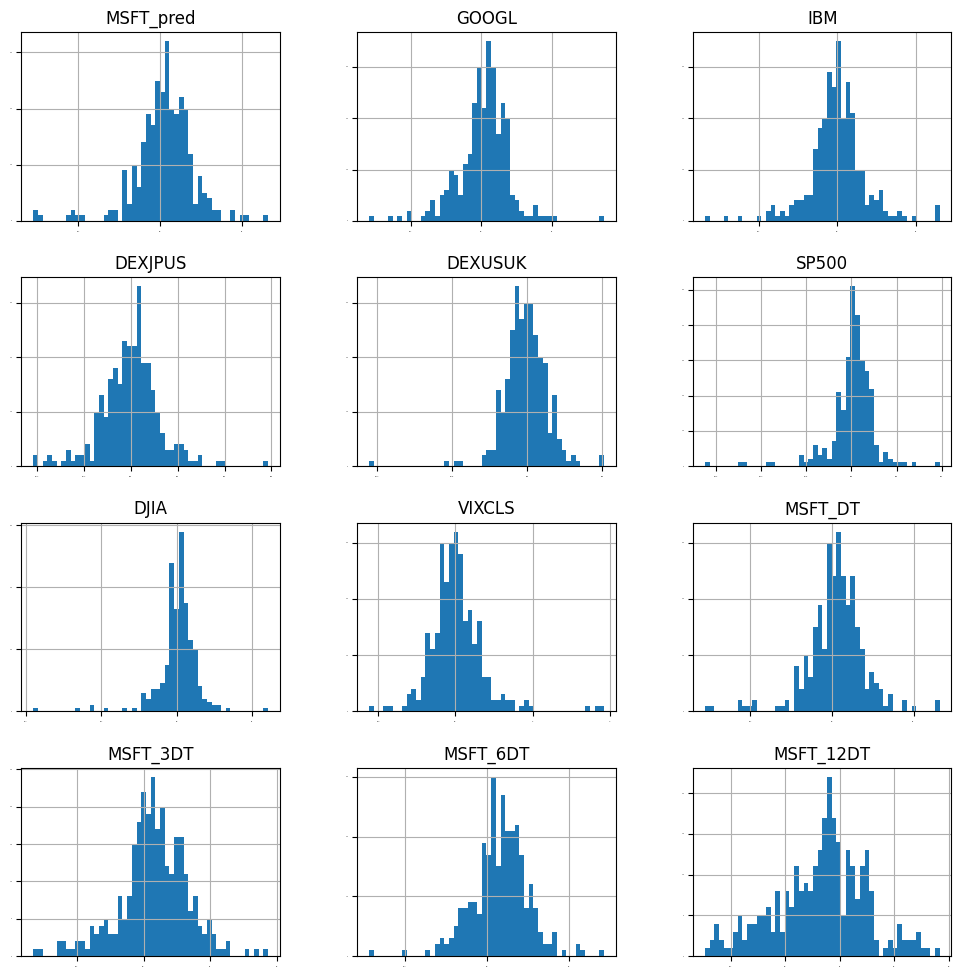

In [15]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

El histograma anterior muestra la distribución de cada serie individualmente. A continuación, veamos la distribución de densidad en la misma escala del eje x.

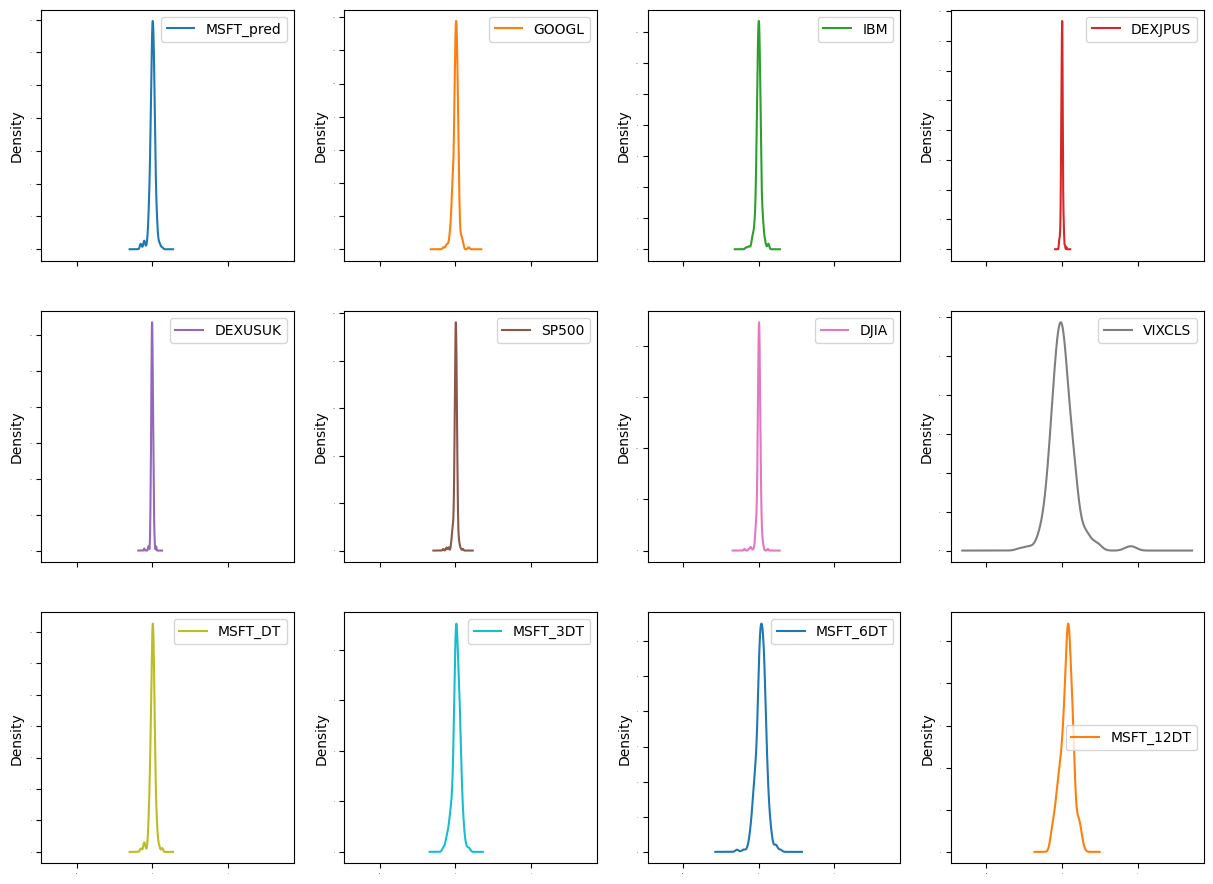

In [16]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Podemos ver que el VIX tiene una varianza mucho mayor en comparación con las otras distribuciones.

Para tener una idea de la interdependencia de los datos, observamos el diagrama de dispersión y la matriz de correlación.

<Axes: title={'center': 'Correlation Matrix'}>

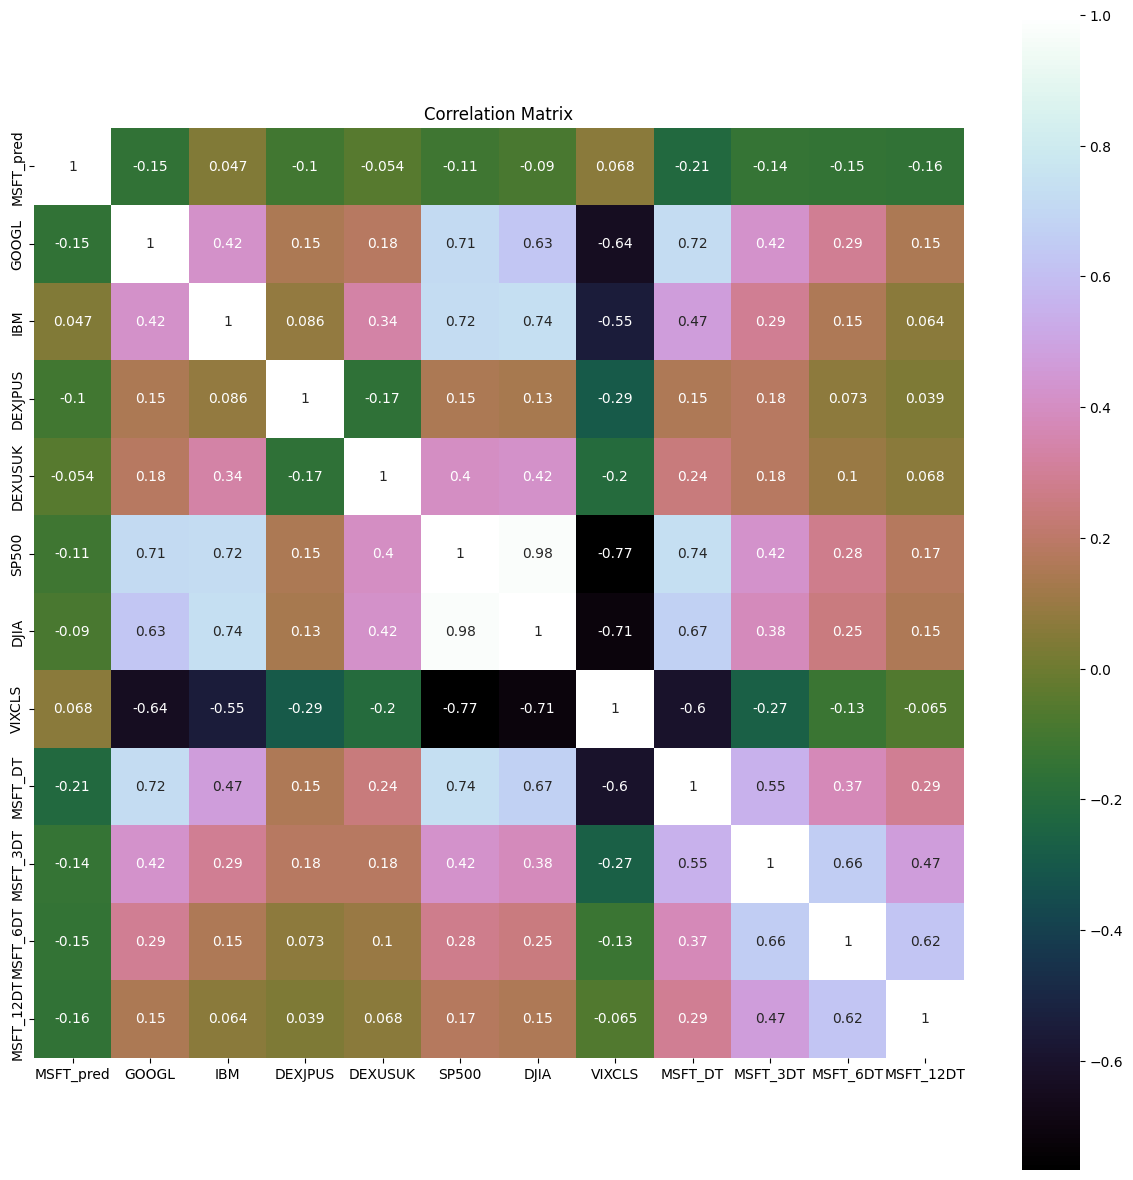

In [17]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Mirando el gráfico de correlación anterior, ¿qué se puede concluir?

<Figure size 1500x1500 with 0 Axes>

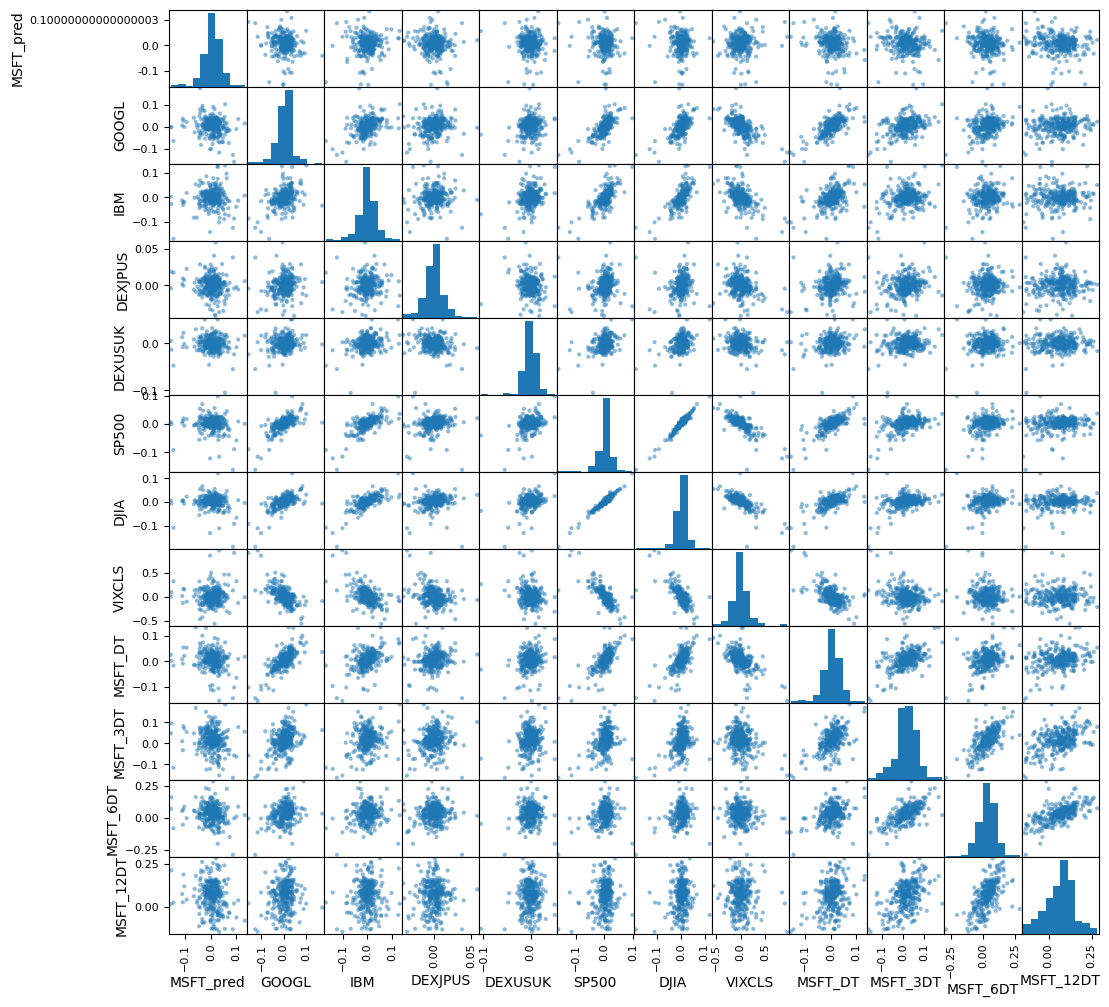

In [18]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Mirando el gráfico de dispersión anterior, ¿vemos alguna relación lineal de la variable predicha con otra variable?

<a id='2.3'></a>
## 3.3. Análisis de la serie de tiempo

A continuación, se observa la descomposición de nuestra serie temporal

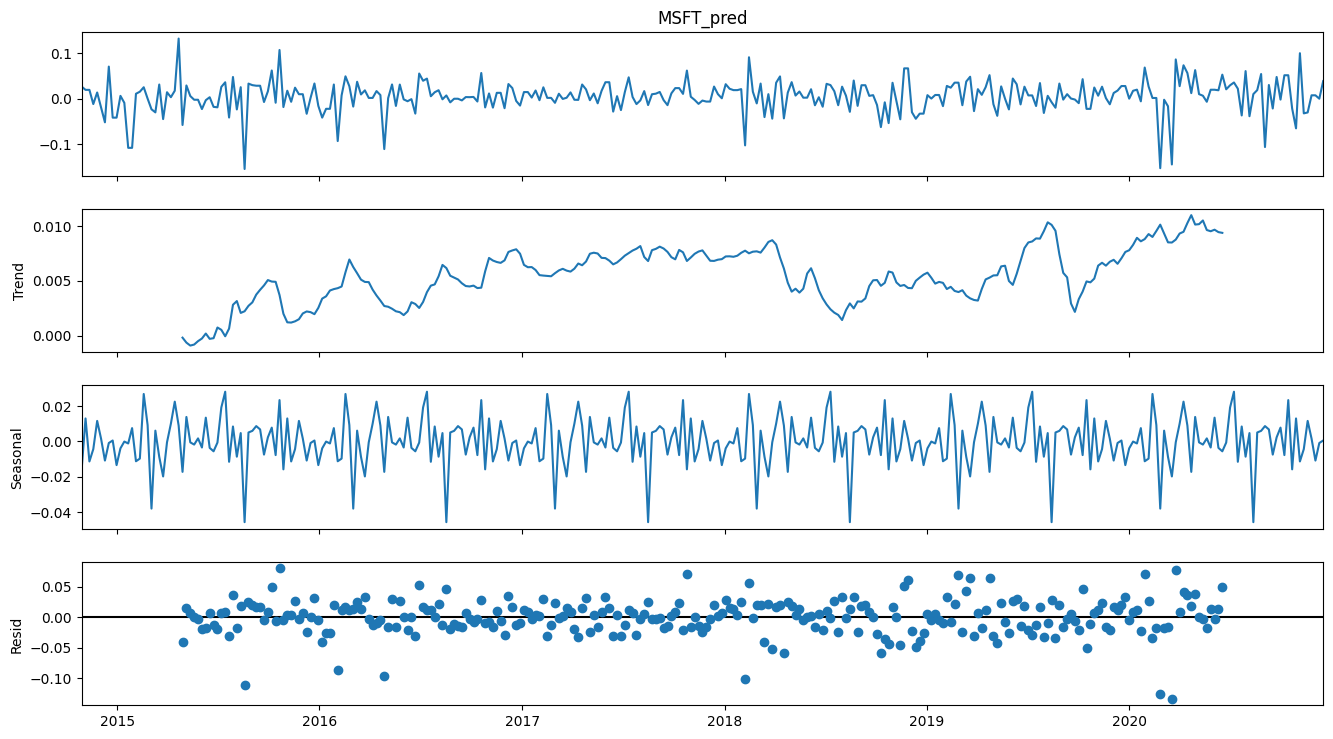

In [19]:
res = sm.tsa.seasonal_decompose(Y, model = "additive")
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Que se puede concluir de esta gráfica?

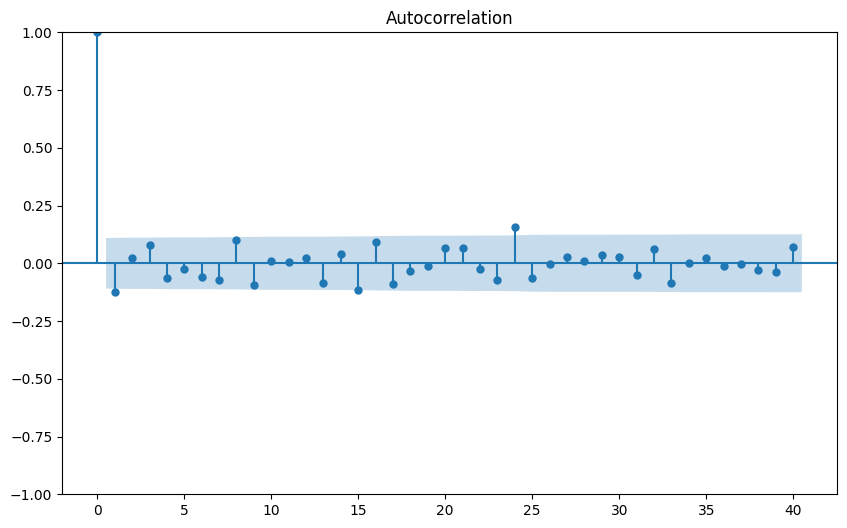

In [20]:
plt.rc("figure", figsize=(10,6))
plot_acf(Y, lags=40);
plt.show()

<a id='3'></a>
## 4. Preparación de los datos

<a id='3.2'></a>
## 4.2. Selección de características

Usamos la función SelectKBest de sklearn para tener una idea de la importancia de las características

In [21]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,13.301868
GOOGL,8.508902
MSFT_12DT,6.972400
MSFT_6DT,5.151760
MSFT_3DT,4.918168
SP500,3.735302
DEXJPUS,3.510921
DJIA,2.280848
VIXCLS,2.077252


Cuál de estas características es de las más importantes?

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

<a id='4.1'></a>
## 5.1. Dividir el conjunto en entrenamiento y test

A continuación, comenzamos dividiendo nuestros datos en conjunto de entrenamiento y test. Si vamos a utilizar modelos de series temporales, tenemos que dividir los datos en series continuas.

In [22]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Métricas de evaluación

In [23]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Comparación de modelos y algoritmos

<a id='4.3.1'></a>
### 5.3.1 Modelos de aprendizaje de máquina

##### Algoritmos de regresión y regresión de árbol

In [24]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Algoritmos basados en redes neuronales

In [25]:
models.append(('MLP', MLPRegressor()))

##### Ensamble de modelos

In [26]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Una vez que hemos seleccionado todos los modelos, hacemos un loop sobre cada uno de ellos. Primero ejecutamos el análisis de K-fold. A continuación, ejecutamos el modelo en todo el conjunto de datos de entrenamiento y prueba.

In [27]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    kfold = TimeSeriesSplit(n_splits = num_folds)

    # Converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001360 (0.001198) 0.000985 0.001855
LASSO: 0.000926 (0.000521) 0.001063 0.002002
EN: 0.000926 (0.000521) 0.001063 0.002002
KNN: 0.001375 (0.000596) 0.000807 0.002055
CART: 0.002502 (0.001034) 0.000000 0.002688
SVR: 0.002868 (0.001103) 0.002181 0.002926
MLP: 0.001987 (0.001466) 0.001113 0.002157
ABR: 0.001213 (0.000691) 0.000500 0.001878
GBR: 0.001453 (0.000965) 0.000122 0.002302
RFR: 0.001227 (0.000716) 0.000139 0.002109
ETR: 0.001201 (0.000707) 0.000000 0.002132


#### Resultados de K Fold 

Estamos mirando los resultados de K Fold

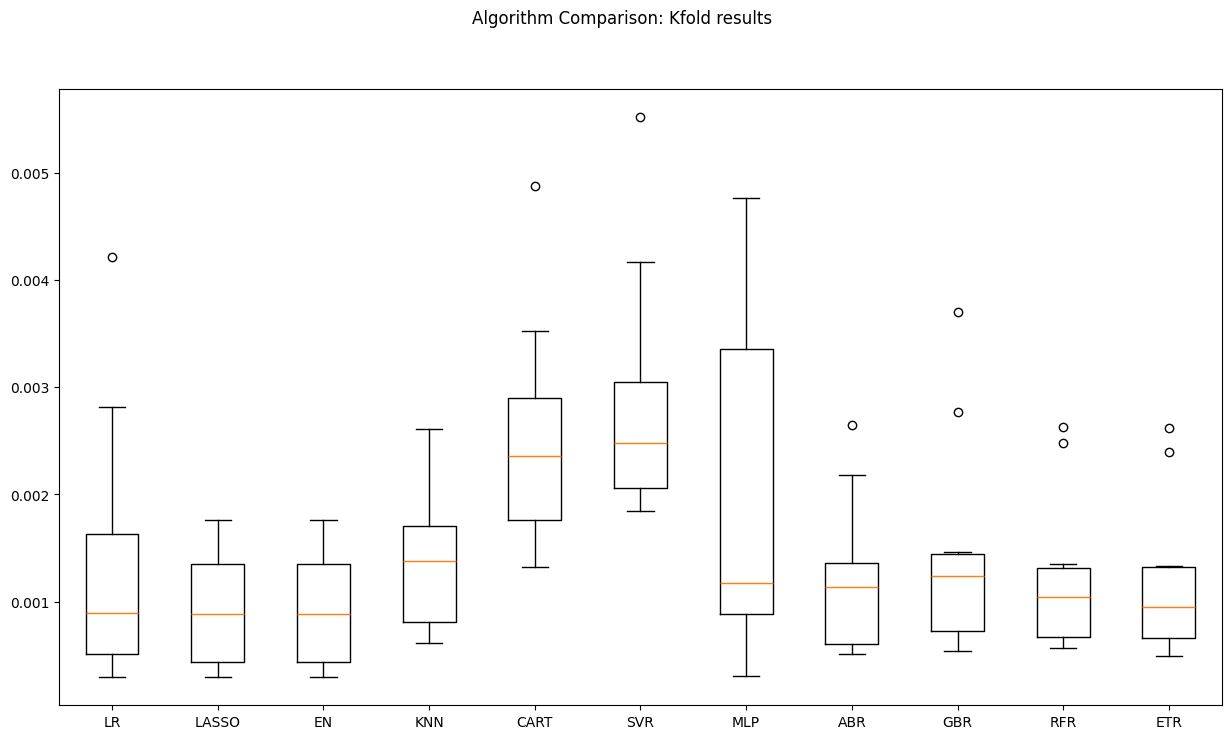

In [28]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Vemos que la regresión lineal y la regresión regularizada, incluida la regresión de Lasso (LASSO) y la red elástica (EN), parecen hacer un buen trabajo.

#### Error en entrenamiento y test

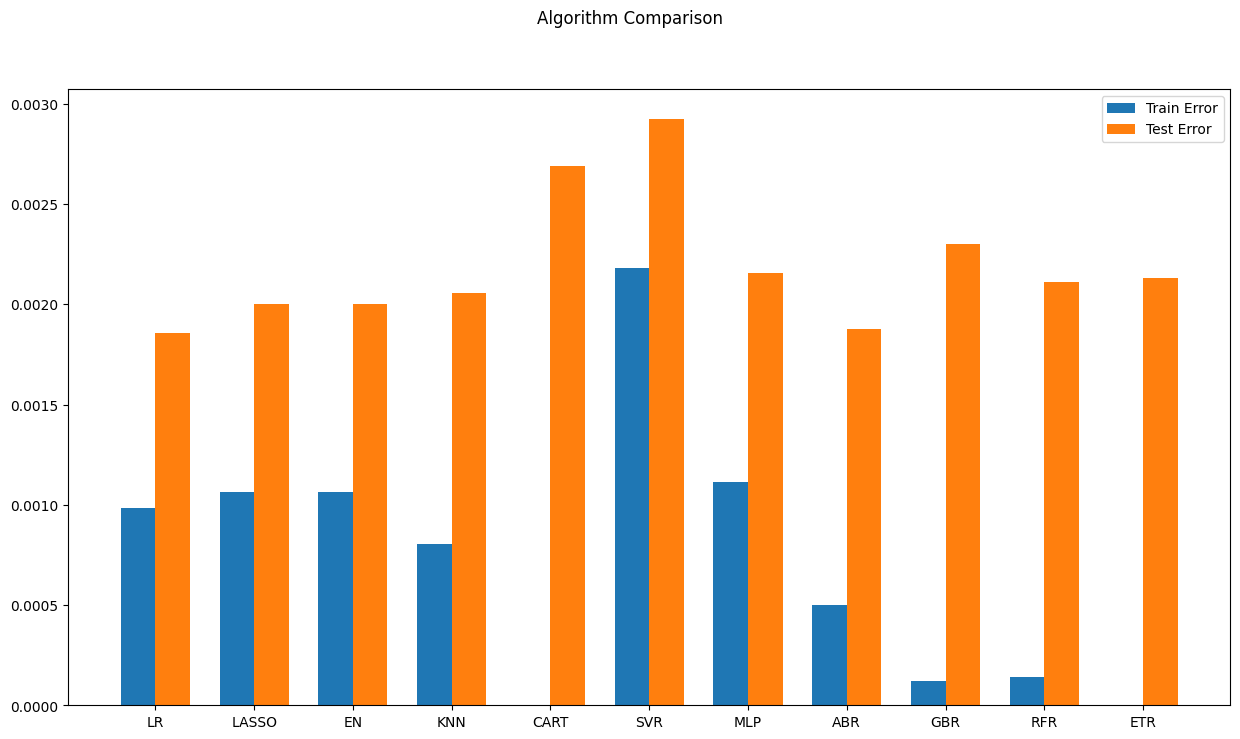

In [29]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Mirando el error de entrenamiento y test, aún vemos un mejor desempeño de los modelos lineales. Algunos de los algoritmos, como el regresor del árbol de decisión (CART), se sobreajustaron en los datos de entrenamiento y produjeron un error muy alto en el conjunto de prueba, por lo que estos modelos deben evitarse. Los modelos de ensamble, como la regresión de aumento de gradiente (GBR) y la regresión de bosque aleatorio (RFR) tienen un sesgo bajo (low bias) pero una varianza alta (high variance) (sobreajuste). También vemos que el algoritmo de la red neuronal artificial (que se muestra como MLP es el gráfico) muestra errores más altos tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que quizás se deba a la relación lineal de las variables que ANN no capturó con precisión o hiperparámetros inadecuados o entrenamiento insuficiente del modelo

<a id='4.3.1'></a>
### 5.3.1 Series de tiempo basado en ARIMA

Primero preparemos el conjunto de datos para los modelos ARIMA, teniendo solo las variables correlacionadas como variables exógenas.

### Modelo en series de tiempo - Modelo ARIMA 

In [30]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [31]:
modelARIMA=ARIMA(endog = Y_train, exog = X_train_ARIMA, order=(1,0,0))
model_fit = modelARIMA.fit()

In [32]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

np.float64(0.0019135323270571085)

#### Añadir los nuevos resultados

In [33]:
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)
names.append("ARIMA")

## Comparación de todos los algoritmos de forma general

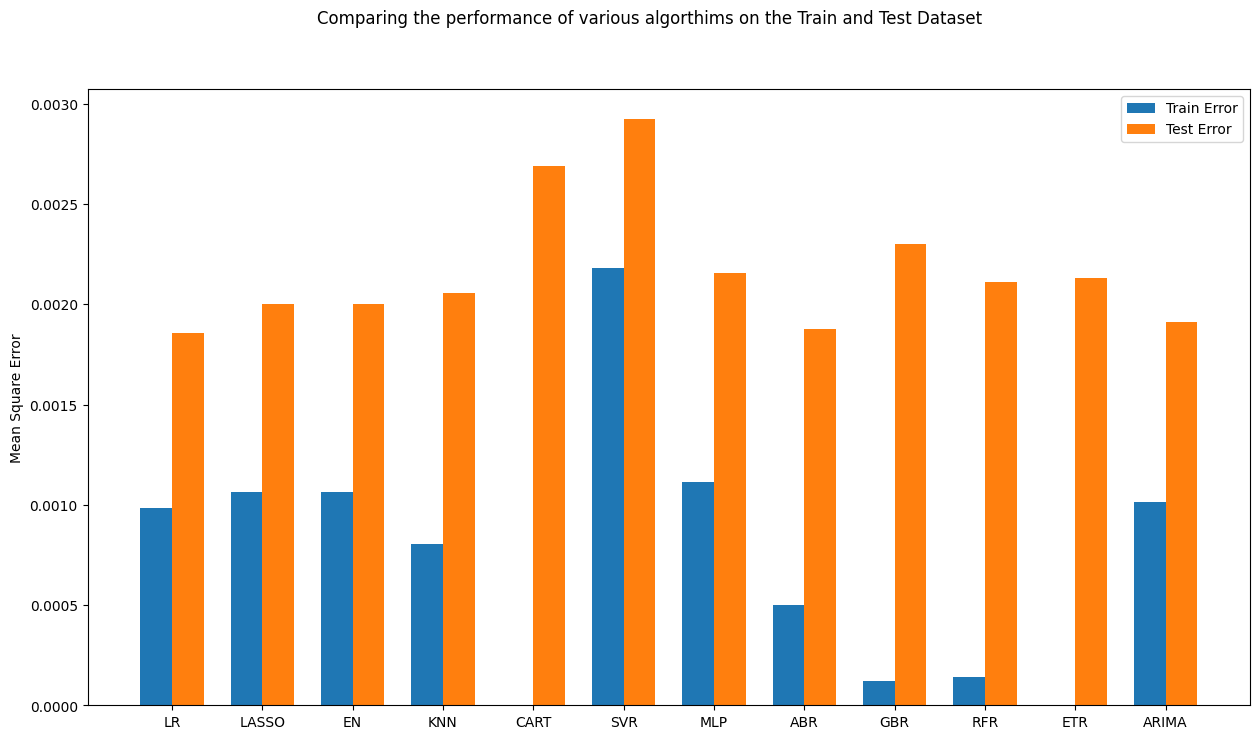

In [34]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Mirando el gráfico anterior, encontramos un modelo ARIMA basado en series de tiempo comparable a los modelos de regresión lineal supervisada como Linear Regression (LR), Lasso Regression (LASSO) y Elastic Net (EN). Esto puede deberse principalmente a la fuerte relación lineal como se discutió anteriormente. Por lo tanto, seleccionamos el modelo ARIMA para el ajuste del modelo.

<a id='5'></a>
# 6. Ajuste de modelos y grilla de busqueda

Como se muestra en el gráfico anterior, el modelo ARIMA es uno de los mejores, por lo que realizamos el ajuste del modelo ARIMA. El orden predeterminado del modelo ARIMA es [1,0,0]. Realizamos una búsqueda en cuadrícula con diferentes combinaciones p, d y q en el orden del modelo ARIMA.

In [35]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0010180
ARIMA(0, 0, 1) MSE=0.0010156
ARIMA(0, 0, 2) MSE=0.0010156
ARIMA(0, 1, 0) MSE=0.0018915
ARIMA(0, 1, 1) MSE=0.0010494
ARIMA(0, 1, 2) MSE=0.0010499
ARIMA(0, 2, 0) MSE=0.0052079
ARIMA(0, 2, 1) MSE=0.0019398
ARIMA(0, 2, 2) MSE=0.0011329
ARIMA(1, 0, 0) MSE=0.0010157
ARIMA(1, 0, 1) MSE=0.0010156
ARIMA(1, 0, 2) MSE=0.0010144
ARIMA(1, 1, 0) MSE=0.0015178
ARIMA(1, 1, 1) MSE=0.0010670
ARIMA(1, 1, 2) MSE=0.0010485
ARIMA(1, 2, 0) MSE=0.0032501
ARIMA(1, 2, 1) MSE=0.0016255
ARIMA(1, 2, 2) MSE=0.0018941
ARIMA(2, 0, 0) MSE=0.0010156
ARIMA(2, 0, 1) MSE=0.0010156
ARIMA(2, 0, 2) MSE=0.0010156
ARIMA(2, 1, 0) MSE=0.0013507
ARIMA(2, 1, 1) MSE=0.0010638
ARIMA(2, 1, 2) MSE=0.0010510
ARIMA(2, 2, 0) MSE=0.0024557
ARIMA(2, 2, 1) MSE=0.0013987
ARIMA(2, 2, 2) MSE=0.0015386
ARIMA(3, 0, 0) MSE=0.0010153
ARIMA(3, 0, 1) MSE=0.0010154
ARIMA(3, 0, 2) MSE=0.0010154
ARIMA(3, 1, 0) MSE=0.0012928
ARIMA(3, 1, 1) MSE=0.0010778
ARIMA(3, 1, 2) MSE=0.0010499
ARIMA(3, 2, 0) MSE=0.0021747
ARIMA(3, 2, 1)

<a id='6'></a>
# 7. Finalización

<a id='6.1'></a>
## 7.1. Resultados en el conjunto de test

In [36]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=(2,0,1))
model_fit_tuned = modelARIMA_tuned.fit()

In [37]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0019135323270571085


Después de ajustar el modelo y elegir el mejor modelo ARIMA, seleccionamos este modelo y se puede utilizar para fines de modelado.

<a id='6.2'></a>
## 7.2. Guardar el modelo

In [38]:
# Save Model Using Pickle
import pickle as pkl

# save the model to disk
filename = './data/finalized_model.sav'
pkl.dump(model_fit_tuned, open(filename, 'wb'))

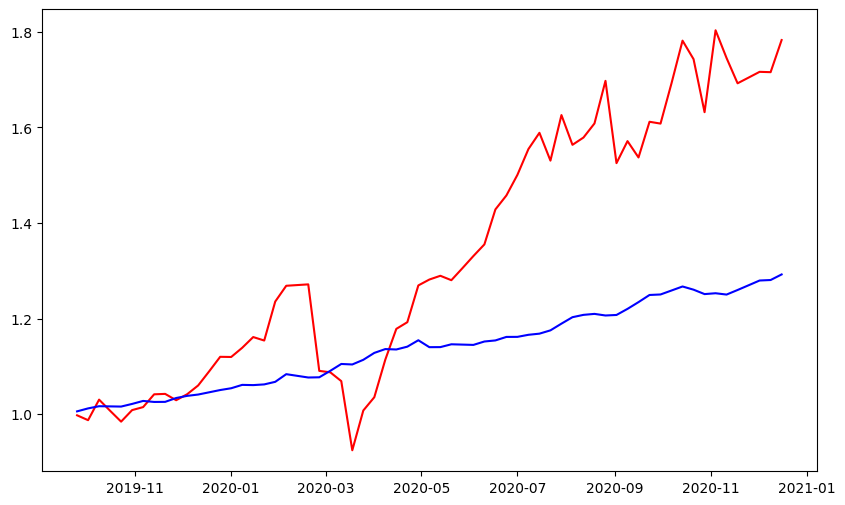

In [39]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

### Resumen

Podemos concluir que los modelos simples (regresión lineal, regresión regularizada (es decir, Lasso y red elástica)) junto con el modelo de serie temporal como ARIMA son enfoques de modelado prometedores para el problema de predicción de precios de activos. Estos modelos pueden permitir a los profesionales financieros modelar dependencias de tiempo con un enfoque muy flexible. El enfoque general presentado en este estudio de caso puede ayudarnos a encontrar sobreajuste y desajuste, que son algunos de los desafíos clave en la predicción.

También debemos tener en cuenta que podemos usar un mejor conjunto de indicadores, como la relación P/E, el volumen de negociación, los indicadores técnicos o los datos de noticias, lo que podría conducir a mejores resultados.

En general, creamos un marco de modelado de series de tiempo y regresión supervisada que nos permite realizar predicciones de clases de activos utilizando datos históricos para generar resultados y analizar el riesgo.
